In [1]:
import sys

!{sys.executable} -m pip install xgboost

In [2]:
import sys

!{sys.executable} -m pip install lightgbm

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re 
import time
import joblib
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)
pd.set_option('display.precision', 8)
sns.set(style="darkgrid",font_scale=1.5)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV , KFold
from sklearn.metrics import mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge , ElasticNet , Lasso
from sklearn.ensemble import RandomForestRegressor  , AdaBoostRegressor 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [5]:
dataset = pd.read_csv('housePrice.csv')

### Shape of dataset

In [6]:
print(f'The shsape of dataset is: {dataset.shape}')

The shsape of dataset is: (3479, 8)


### Columns of dataset

In [7]:
print(f'The shsape of dataset is: {dataset.columns}')

The shsape of dataset is: Index(['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address', 'Price',
       'Price(USD)'],
      dtype='object')


#### View of dataset

In [8]:
dataset.head(10)

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1850000000.0,61666.67
1,60,1,True,True,True,Shahran,1850000000.0,61666.67
2,79,2,True,True,True,Pardis,550000000.0,18333.33
3,95,2,True,True,True,Shahrake Qods,902500000.0,30083.33
4,123,2,True,True,True,Shahrake Gharb,7000000000.0,233333.33
5,70,2,True,True,False,North Program Organization,2050000000.0,68333.33
6,87,2,True,True,True,Pardis,600000000.0,20000.00
7,59,1,True,True,True,Shahran,2150000000.0,71666.67
8,54,2,True,True,False,Andisheh,493000000.0,16433.33
9,71,1,True,True,True,West Ferdows Boulevard,2370000000.0,79000.00


As it can be seen two columns(Price & Price(USD)) are the same ,so we use Price column as our y .

#### Checking the Duplicates Dastaset

In [9]:
print(f'Number of Duplicated in our dataset is: {dataset.duplicated().sum()}')

Number of Duplicated in our dataset is: 208


In [10]:
print(f'The percentage of Duplicated in our dataset in is: {round(dataset.duplicated().sum() * 100 / len(dataset), 1)}')

The percentage of Duplicated in our dataset in is: 6.0


So there are a verity of data which have duplicated .

#### Checking the dataset types

In [11]:
print("The types of oue features in Dataset are: ")
dataset.dtypes

The types of oue features in Dataset are: 


Area           object
Room            int64
Parking          bool
Warehouse        bool
Elevator         bool
Address        object
Price         float64
Price(USD)    float64
dtype: object

Except Area feature , all of them have right type . we have to change its type later .

#### Checking the total missing values and percentage in our Dataset

In [12]:
missing_values = dataset.isnull().sum().to_frame().rename(columns = {0:'Missing values'})
missing_values["Percentage of missing values"] = round((dataset.isnull().sum() * 100) / len(dataset), 1)
missing_values

,Missing values,Percentage of missing values
Area,0,0.0
Room,0,0.0
Parking,0,0.0
Warehouse,0,0.0
Elevator,0,0.0
Address,23,0.7
Price,0,0.0
Price(USD),0,0.0


* Due to Address feature plays an important role and it must be exact , we cant replace missing values with anything .
* Consequently , we will drop those missing values later

#### Checking the cardinality of categorical feature

In [13]:
print(f'The cardinality of categorical features is: {dataset.Address.nunique()}')

The cardinality of categorical features is: 192


* It has somehow high cardinality , but as I said it is important feature , so we use of this feature .
* Because of high cardinality we cant show this feature on chart

#### Checking price feature(y)

Text(0.5, 1.0, 'Price Distribution')

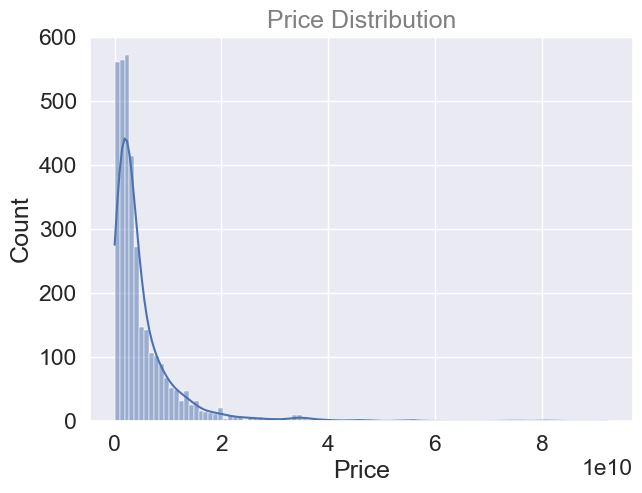

In [14]:
plt.figure(figsize = (7, 5))
sns.histplot(x = dataset["Price"], kde = True, palette = 'Set2', bins = 100)
plt.title('Price Distribution', color = 'gray')

* As it can be seen , Price feature is Right-Skewed.
* Most houses have roughly close price in one third of the first part
* Outliers are obvious now(on the right side)

#### Checking the number of rooms

Text(0.5, 1.0, 'Number of Rooms')

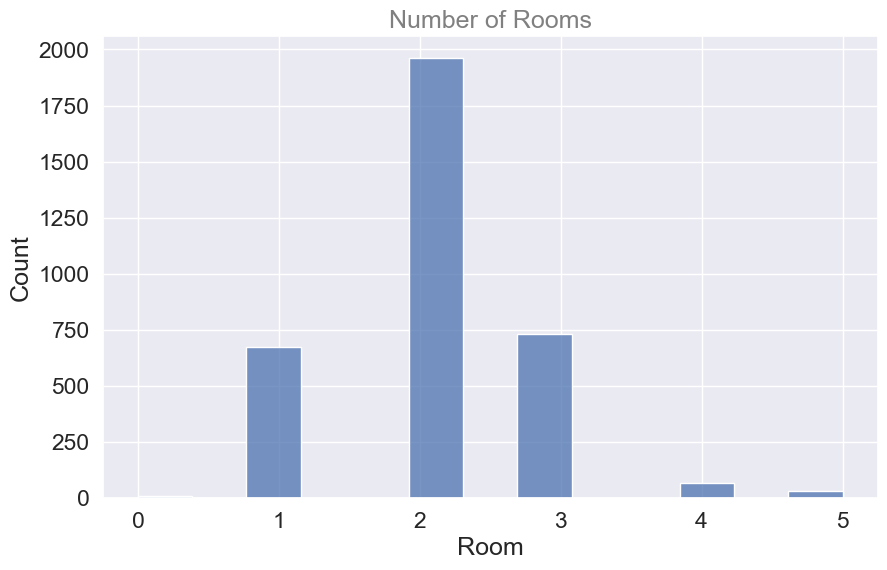

In [15]:
plt.figure(figsize = (10, 6))
sns.histplot(dataset["Room"], palette = 'Set2')
plt.title("Number of Rooms", color = 'gray')

* About 2000 houses have exactly 2 rooms (most houses)
* Distribution of 1 and 3 rooms are roughly the same (a little more 3 rooms)
* we have not many houses with 4 or 5 rooms (in total about 150 houses)
houses without room is rarely seen

Mean of rooms is roughly 2.

#### Checking Booleadn Features

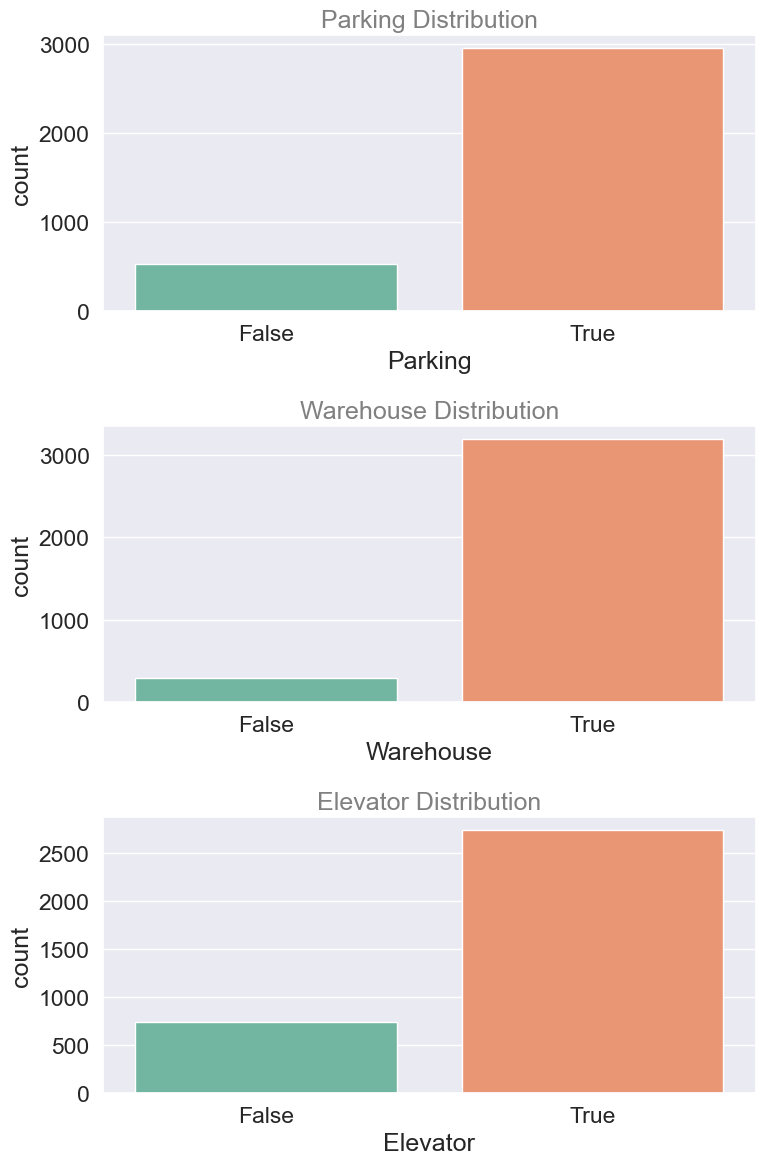

In [16]:
boolean_cols = ['Parking', 'Warehouse', 'Elevator']
plt.figure(figsize = (8, 12))
for inx, col in enumerate(boolean_cols):
    plt.subplot(3, 1, inx + 1)
    sns.countplot(x = col, data = dataset, palette = 'Set2')
    plt.title(f'{col} Distribution', color = 'gray')
    plt.tight_layout()

* Most houses have Parking , Warehouse and Elevator (all these three features )
* Most houses have Warehouse.(houses without warehouse are very low)
* Those houses without Parking and Elevator have the same distribution(less than 1000 more than 500)

#### Change the Type of Area

In [17]:
dataset.dtypes

Area           object
Room            int64
Parking          bool
Warehouse        bool
Elevator         bool
Address        object
Price         float64
Price(USD)    float64
dtype: object

* The type of Area must be changed if we want to show and do feature engineering .
* To be possible to change its type we need to remove comma between numbers than we are capable changing its type.

In [18]:
dataset["Area"] = dataset["Area"].apply(lambda x : re.sub(',', '', x))
dataset["Area"] = pd.to_numeric(dataset["Area"])

In [19]:
dataset.dtypes

Area            int64
Room            int64
Parking          bool
Warehouse        bool
Elevator         bool
Address        object
Price         float64
Price(USD)    float64
dtype: object

#### Dividing Area feaure to a new feature¶

In [20]:
dataset.Area.describe()

count    3.47900000e+03
mean     8.74399984e+06
std      3.16726629e+08
min      3.00000000e+01
25%      6.90000000e+01
50%      9.00000000e+01
75%      1.20000000e+02
max      1.61600000e+10
Name: Area, dtype: float64

* We are going to divide Area feature to 4 category : Small(0-30) - AveUnderMean(30-90) - AveUpperMean(90-120)- High(120-...)

* except these features other will be replaced to nan values

In [21]:
Area_new_feature = []

for i in dataset['Area']:
    if i <= 30:
        Area_new_feature.append("Small")

    elif (i > 30 and i<=90):
        Area_new_feature.append("AveUnderMean")

    elif (i>90 and i <= 120):
        Area_new_feature.append("AveUpperMean")

    elif i > 120:
        Area_new_feature.append("High")
    else:
            Area_new_feature.append(np.nan)

dataset["AreaSize"] = Area_new_feature

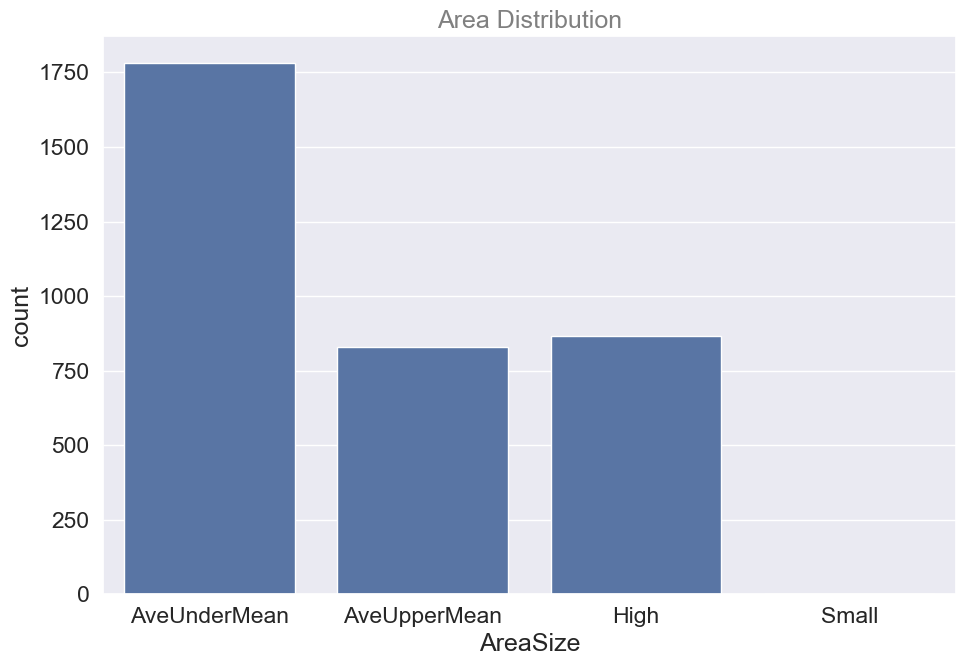

In [22]:
plt.figure(figsize = (10, 7))
sns.countplot(x = "AreaSize", data = dataset)
plt.title("Area Distribution", color = 'gray')
plt.tight_layout()

* As we can see about half of houses have between 30-90 meters(m2)
* Houses with 90-120 meters have the same contribution with houses which have more than 120 meters
* we can realize that right-skewed has happened.(outliers most are on the right part)
* very low houeses are with less than 30 meters size.

#### Dividing Price feaure to a new feature

we are going to determine 4 level for this feature : Cheap , AveUnderMean , AveUpperMean , Expensive

cheap : 0-25%

AveUnderMean : 25%-50%

AveUpperMean : 50%-75%

Expensive : upper 75%

In [23]:
Price_new_feature = []

H25 = dataset['Price'].describe()[4]
H50 = dataset['Price'].describe()[5]
H75 = dataset['Price'].describe()[6]

for i in dataset['Price']:

    if    i <= H25:
        Price_new_feature.append("Cheap")

    elif (i > H25 and i<= H50):
        Price_new_feature.append("AveUnderMean")

    elif (i > H50 and i <= H75):
       Price_new_feature.append("AveUpperMean")

    elif  i > H75:
        Price_new_feature.append("Expensive")

    else:
        Price_new_feature.append(np.nan)

dataset["PriceLevel"] = Price_new_feature

<Axes: xlabel='PriceLevel', ylabel='count'>

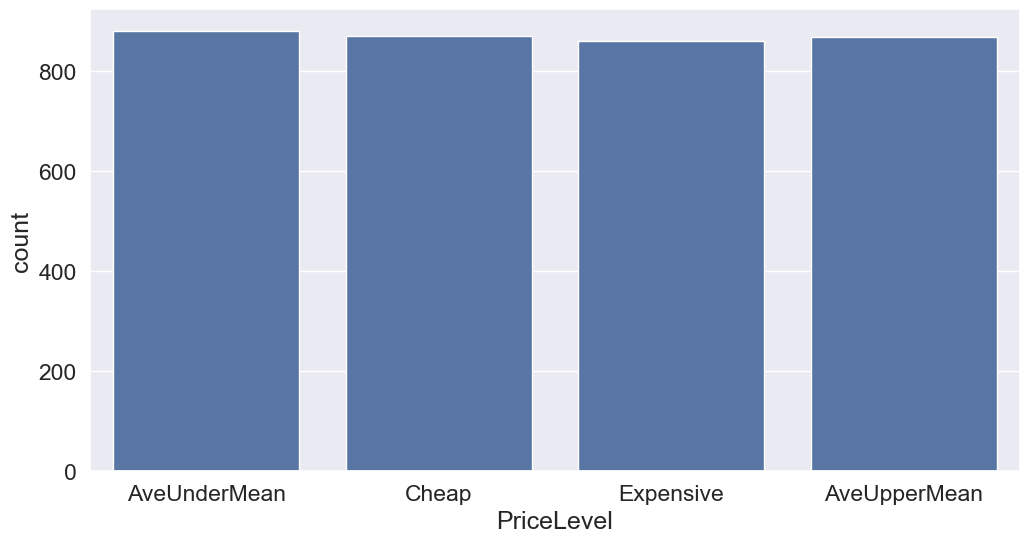

In [24]:
plt.figure(figsize=(12,6))
sns.countplot(x='PriceLevel' , data = dataset )

We have very balanced distribution in 4 parts

## Data Pre-Processing

In [25]:
dataset.sample(10)

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),AreaSize,PriceLevel
2665,106,2,True,True,True,Gholhak,6400000000.0,213333.33,AveUpperMean,Expensive
1787,113,2,True,True,True,Ekhtiarieh,6000000000.0,200000.00,AveUpperMean,AveUpperMean
823,145,3,True,True,True,Gheitarieh,11600000000.0,386666.67,High,Expensive
1441,145,3,True,True,True,Heravi,9000000000.0,300000.00,High,Expensive
1198,108,2,True,True,True,West Ferdows Boulevard,3950000000.0,131666.67,AveUpperMean,AveUpperMean
1708,124,3,True,True,True,Southern Janatabad,5950000000.0,198333.33,High,AveUpperMean
595,88,2,True,True,True,Pardis,1900000000.0,63333.33,AveUnderMean,AveUnderMean
2330,51,1,True,True,True,Salsabil,1150000000.0,38333.33,AveUnderMean,Cheap
600,200,4,True,True,True,Saadat Abad,15000000000.0,500000.00,High,Expensive
2855,37,1,False,True,False,Azarbaijan,950000000.0,31666.67,AveUnderMean,Cheap


#### Discover Missing values

In [26]:
missing_values = dataset.isnull().sum().to_frame().rename(columns = {0: 'Missing values'})
missing_values["Percentage of missing values"] = round((dataset.isnull().sum() * 100) / len(dataset), 1)
print(f'Total of missing values: {dataset.isnull().sum().sum()}')
missing_values.style.highlight_max(color = "red")

Total of missing values: 23


,Missing values,Percentage of missing values
Area,0,0.000000
Room,0,0.000000
Parking,0,0.000000
Warehouse,0,0.000000
Elevator,0,0.000000
Address,23,0.700000
Price,0,0.000000
Price(USD),0,0.000000
AreaSize,0,0.000000
PriceLevel,0,0.000000


* As I said above , because Address (location of house) is crucial , wa cant replace missing values with like(most frequent)
(if we do that our model doesnt have good prediction)
* So , we easily drop those missing values

In [27]:
dataset.dropna(inplace = True)

In [28]:
print(f'Total of missing values: {dataset.isnull().sum().sum()}')

Total of missing values: 0


#### Discover Duplicated values

In [29]:
duplicated_values = dataset[dataset.duplicated()]
print(f'The number of Duplicated values : {len(duplicated_values)}')
print(f'The Percentage of Duplicated Values : {round(len(duplicated_values) / len(dataset) * 100)}%')

The number of Duplicated values : 208
The Percentage of Duplicated Values : 6%


* We have 208 duplicated values . We can easily drop them

In [30]:
dataset.drop_duplicates(inplace = True)
dataset.reset_index(inplace = True)
dataset.drop('index', axis = 1, inplace = True)
dataset.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),AreaSize,PriceLevel
0,63,1,True,True,True,Shahran,1850000000.0,61666.67,AveUnderMean,AveUnderMean
1,60,1,True,True,True,Shahran,1850000000.0,61666.67,AveUnderMean,AveUnderMean
2,79,2,True,True,True,Pardis,550000000.0,18333.33,AveUnderMean,Cheap
3,95,2,True,True,True,Shahrake Qods,902500000.0,30083.33,AveUpperMean,Cheap
4,123,2,True,True,True,Shahrake Gharb,7000000000.0,233333.33,High,Expensive


In [31]:
print(f"The new shape of Dataset is : {dataset.shape}")

The new shape of Dataset is : (3248, 10)


In [32]:
dataset.dtypes

Area            int64
Room            int64
Parking          bool
Warehouse        bool
Elevator         bool
Address        object
Price         float64
Price(USD)    float64
AreaSize       object
PriceLevel     object
dtype: object

* About dtypes every thing is fine .
* We are going to check and discover each feature .

In [33]:
AreaSize_feature = dataset["AreaSize"].value_counts().to_frame()
AreaSize_feature["AreaSizeMean"] = round(dataset.groupby('AreaSize')["Price"].mean())
AreaSize_feature.sort_values('AreaSize', ascending = False)

,count,AreaSizeMean
AreaSize,,
Small,1,500000000.0
High,823,13569665371.0
AveUpperMean,780,4218685769.0
AveUnderMean,1644,2027991180.0


* Obviously with increasing the meter of a house the price will raise and Mean will be raised too .

* Distribution of houses according to Meter is : AveUnderMean - High - AveUpperMean - Small

* There is just a house with a small size.(it's an outlier)

In [34]:
room_feature = round(dataset["Room"].value_counts(normalize=True) * 100 ).to_frame()
room_feature["MeanPrice"] = round(dataset.groupby('Room')["Price"].mean())
room_feature.sort_index()

,proportion,MeanPrice
Room,,
0,0.0,8715555556.0
1,19.0,1717831520.0
2,56.0,3363038373.0
3,21.0,11043108790.0
4,2.0,25681220588.0
5,1.0,33734393939.0


* We can see the distribution of houses with :
In row 2 , 3 , 1 , 4 , 5 and 0 rooms have the highest distribution.

* Mean price for each has been shown.
* Obviously, with raising the number of rooms the cost will be increased.
(Duplicate the cost for each 1 room (except 4rooms to 5rooms)

In [35]:
Parking_feature = dataset["Parking"].value_counts().to_frame()
Parking_feature["ParkingMean"] = round(dataset.groupby("Parking")["Price"].mean())
Parking_feature

,count,ParkingMean
Parking,,
True,2745,6162136357.0
False,503,1745253877.0


* As we can see , most houses have parking (about 5.5x versus those without parking)

* Those houses with parking have higher costs.(about fourfold)(transparently Parking is an important feature for price)

In [36]:
Warehouse_feature =dataset["Warehouse"].value_counts().to_frame()
Warehouse_feature["WarehouseMean"] = round(dataset.groupby("Warehouse")["Price"].mean())
Warehouse_feature

,count,WarehouseMean
Warehouse,,
True,2969,5753694139.0
False,279,2545552330.0


* Most houses have Warehouse (about 10x versus those without Warehouse)

* Houses with warehouse have higher costs . more than duoble

In [37]:
Elevator_feature = dataset["Elevator"].value_counts().to_frame()
Elevator_feature["ElevatorMean"] = round(dataset.groupby("Elevator")["Price"].mean())
Elevator_feature

,count,ElevatorMean
Elevator,,
True,2551,5952952019.0
False,697,3740238737.0


* Most houses have Elevator (about 4x versus those without Elevator)

* Houses with Elevator have higher costs .about 1.5X

* Versus Parking and Warehouse , Elevator has less influence on price

In [38]:
pd.crosstab(dataset["Parking"], dataset["Room"])

Room,0,1,2,3,4,5
Parking,,,,,,
False,7,233,233,24,1,5
True,2,392,1586,670,67,28


* Most houses with 1 room or more have Parking.
* With raising the number of rooms , houses with Parking have increasingly raised.

In [39]:
round(dataset.groupby(["Parking", "Warehouse"])["Price"].mean().to_frame())

Price
Parking Warehouse              
False   False      2488762703.0
        True       1312709434.0
True    False      2657319149.0
        True       6286411279.0

* It can be seen that houses with Warehouse and without Parking have less cost versus those houses with Parking.
* If both features exist in a house , the cost of the house will be high.

In [40]:
round(dataset.groupby(["Room", "Warehouse"])["Price"].mean().to_frame())

Price
Room Warehouse               
0    False      19120750000.0
     True         391400000.0
1    False       1376319608.0
     True        1784436138.0
2    False       1811027972.0
     True        3495459308.0
3    False       7692475000.0
     True       11142534125.0
4    False       3673333333.0
     True       26696969231.0
5    False       9927857143.0
     True       40143846154.0

* Except houses without room , with increasing the number of Rooms and Warehouse existance the cost will be increasingly raised.

In [41]:
dataset["Address"].unique()

array(['Shahran', 'Pardis', 'Shahrake Qods', 'Shahrake Gharb',
       'North Program Organization', 'Andisheh', 'West Ferdows Boulevard',
       'Narmak', 'Saadat Abad', 'Zafar', 'Islamshahr', 'Pirouzi',
       'Shahrake Shahid Bagheri', 'Moniriyeh', 'Velenjak', 'Amirieh',
       'Southern Janatabad', 'Salsabil', 'Zargandeh', 'Feiz Garden',
       'Water Organization', 'ShahrAra', 'Gisha', 'Ray', 'Abbasabad',
       'Ostad Moein', 'Farmanieh', 'Parand', 'Punak', 'Qasr-od-Dasht',
       'Aqdasieh', 'Pakdasht', 'Railway', 'Central Janatabad',
       'East Ferdows Boulevard', 'Pakdasht KhatunAbad', 'Sattarkhan',
       'Baghestan', 'Shahryar', 'Northern Janatabad', 'Daryan No',
       'Southern Program Organization', 'Rudhen', 'West Pars', 'Afsarieh',
       'Marzdaran', 'Dorous', 'Sadeghieh', 'Chahardangeh', 'Baqershahr',
       'Jeyhoon', 'Lavizan', 'Shams Abad', 'Fatemi',
       'Keshavarz Boulevard', 'Kahrizak', 'Qarchak',
       'Northren Jamalzadeh', 'Azarbaijan', 'Bahar',
       'P

In [42]:
len(dataset["Address"].unique())

192

* Because we dont know that all names of addresses have correct writing or human mistake has happened or not, we are going to remove any probable problem in case of existance.

In [43]:
dataset["Address"]=dataset["Address"].apply(lambda x : re.sub('[^a-zA-Z]' ,'' ,x))
dataset["Address"].head().to_frame()

,Address
0,Shahran
1,Shahran
2,Pardis
3,ShahrakeQods
4,ShahrakeGharb


In [44]:
len(dataset["Address"].unique())

192

* Top ten Addresses with the highest repeat

In [45]:
Address_most_repeat = dataset["Address"].value_counts().head(10)

Text(0, 0.5, 'Address')

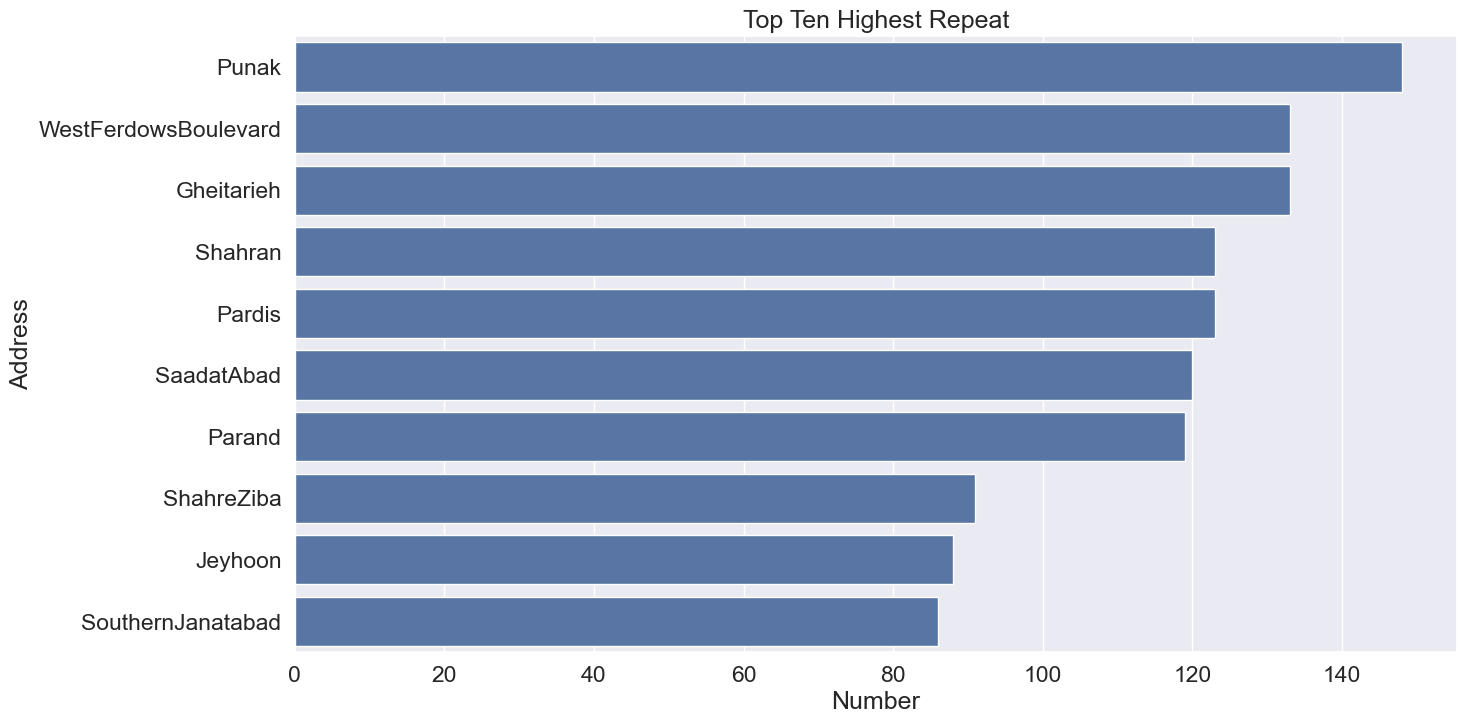

In [46]:
plt.figure(figsize = (15, 8))
sns.barplot(x = Address_most_repeat.values, y = Address_most_repeat.index)
plt.title('Top Ten Highest Repeat')
plt.xlabel('Number')
plt.ylabel("Address")

* Top ten Addresses with the most expensive mean price

In [47]:
Address_feature = round(dataset.groupby('Address')["Price"].mean().to_frame())
Address_Top_Ten_Expensive  = Address_feature.sort_values("Price", ascending = False).head(10)
Address_Top_Ten_Expensive

,Price
Address,
Gandhi,70000000000.0
Lavasan,48000000000.0
Mahmoudieh,33466666667.0
Vanak,32700000000.0
Elahieh,26786352941.0
Argentina,25165000000.0
Zaferanieh,23575148148.0
Velenjak,21381363636.0
Farmanieh,20665803571.0


* Arranging and Statistical review for price feature

In [48]:
round(dataset["Price"].describe()).to_frame()

,Price
count,3248.0
mean,5478117919.0
std,8267916004.0
min,3600000.0
25%,1420000000.0
50%,2977500000.0
75%,6200000000.0
max,92400000000.0


In [49]:
dataset_regular = dataset.copy()
dataset_regular ["Price"]=dataset_regular ["Price"].map('{:,.0f}'.format)
dataset_regular ["Price(USD)"]=dataset_regular ["Price(USD)"].map('{:,.0f}'.format)

* we create new variable to avoid changing the type of Price from numeric to object .
Price and Price(USD) are easily readable now .

In [50]:
dataset_regular.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),AreaSize,PriceLevel
0,63,1,True,True,True,Shahran,"1,850,000,000","61,667",AveUnderMean,AveUnderMean
1,60,1,True,True,True,Shahran,"1,850,000,000","61,667",AveUnderMean,AveUnderMean
2,79,2,True,True,True,Pardis,"550,000,000","18,333",AveUnderMean,Cheap
3,95,2,True,True,True,ShahrakeQods,"902,500,000","30,083",AveUpperMean,Cheap
4,123,2,True,True,True,ShahrakeGharb,"7,000,000,000","233,333",High,Expensive


<Axes: >

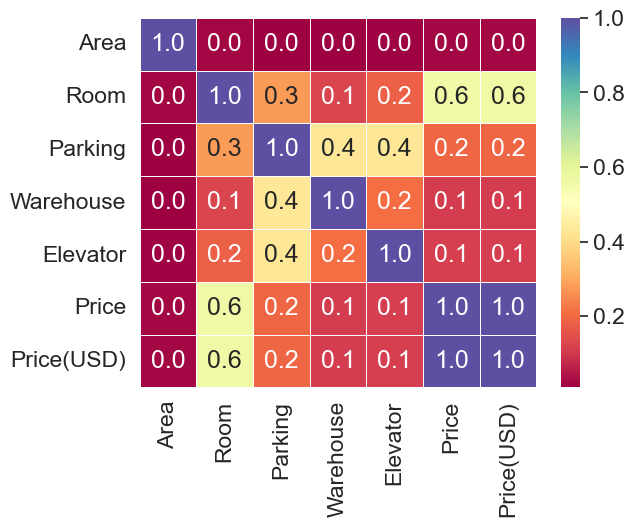

In [51]:
# Select only numeric columns for the correlation matrix
numeric_data = dataset.select_dtypes(include=[float, int, bool])

# Plot the heatmap
sns.heatmap(numeric_data.corr(), annot=True, cmap="Spectral", fmt='.1f', linewidths=.5)


In [52]:
dataset.dtypes

Area            int64
Room            int64
Parking          bool
Warehouse        bool
Elevator         bool
Address        object
Price         float64
Price(USD)    float64
AreaSize       object
PriceLevel     object
dtype: object

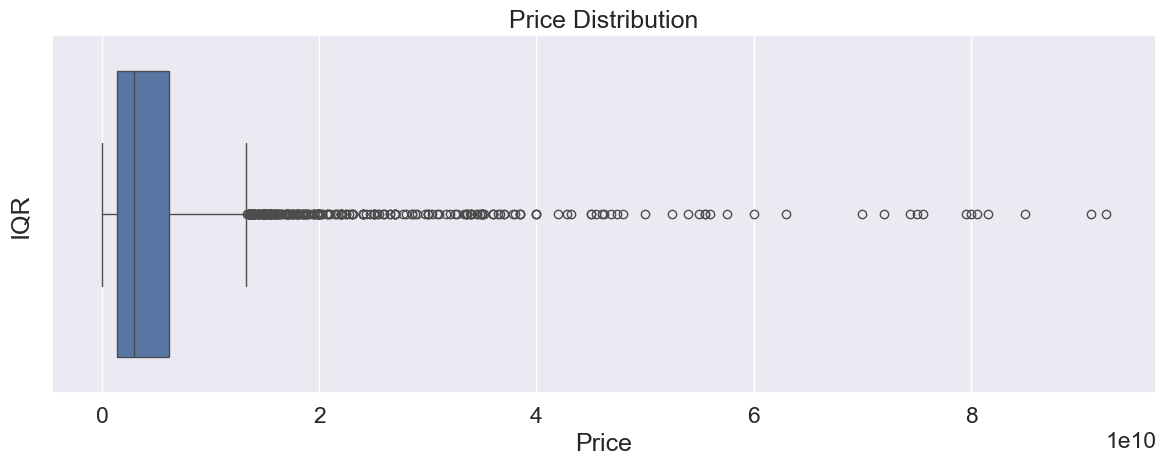

In [53]:
plt.figure(figsize = (12, 5))
sns.boxplot(x = dataset["Price"])
plt.title('Price Distribution')
plt.ylabel("IQR")
plt.tight_layout()

In [54]:
# Select only numeric columns for skewness calculation
numeric_data = dataset.select_dtypes(include=[float, int, bool])

# Calculate skewness for numeric columns
numeric_data.skew()

Area          42.48756230
Room           0.63961595
Parking       -1.90889078
Warehouse     -2.95696183
Elevator      -1.39103722
Price          4.72779323
Price(USD)     4.72779322
dtype: float64

What are outliers in dataset ?

Answer : Outliers are values at the extreme ends of a dataset.

One of the best method to find out outliers : Interquartile range method

Interquartile range method:

1: Sort your data from low to high
2: Identify the first quartile (Q1), the median, and the third quartile (Q3).
3: Calculate your IQR = Q3 – Q1
4: Calculate your upper fence = Q3 + (1.5 * IQR)
5: Calculate your lower fence = Q1 – (1.5 * IQR)
6: Use your fences to highlight any outliers, all values that fall outside your fences.
7: Your outliers are any values greater than your upper fence or less than your lower fence.

In [55]:
def Interquartile_Range(df, target):

    Q1 = np.percentile(df[target], 25)
    Q3 = np.percentile(df[target], 75)

    IQR = Q3 - Q1

    Upper_Fence = Q3 + (1.5 * IQR)
    Lower_Fence = Q1 - (1.5 * IQR)

    print(f'The Upper_Fence for {target} is : {Upper_Fence}')
    print(f'The Lower_Fence for {target} is : {Lower_Fence}')

In [56]:
Interquartile_Range(df = dataset, target = "Price")
print("--" * 100)
Interquartile_Range(df = dataset, target = 'Area')

The Upper_Fence for Price is : 13370000000.0
The Lower_Fence for Price is : -5750000000.0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
The Upper_Fence for Area is : 200.0
The Lower_Fence for Area is : -8.0


* It must be considered that most outliers are on the right side dut to Right_skewed

so , we need to remove outliers on the right(Upper_Fence)

* Among all the features , two of them have noticeable effect : Area and Price

We cant find out outliers from (Room , Parking , Warehouse ,Elevator) features.
It's better to find out outliers first from Price , second Area

In [57]:
PriceUpperFence =  13370000000
AreaUpperFence  = 200
Price_UpperFence_Data =  np.where(dataset["Price"] > PriceUpperFence)
Area_UpperFence_Data  =  np.where(dataset["Area"] > AreaUpperFence)

* We can use of a method and add all the Outliers which are greater than UpperFence for both Price and Area and then

In [58]:
Price_Area_Outliers =np.union1d(Price_UpperFence_Data , Area_UpperFence_Data)
print(f'The length of Outliers is : {len(Price_Area_Outliers)} ')
print(f'The percentage of OUtliers is : {round(len(Price_Area_Outliers)/len(dataset)*100)}%')
dataset_regular.iloc[Price_Area_Outliers].head()

The length of Outliers is : 319 
The percentage of OUtliers is : 10%


,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),AreaSize,PriceLevel
25,160,3,True,True,True,Velenjak,"14,945,000,000","498,167",High,Expensive
57,215,3,True,True,True,Pakdasht,"1,750,000,000","58,333",High,AveUnderMean
76,300,3,True,True,False,Baghestan,"1,500,000,000","50,000",High,AveUnderMean
94,130,2,True,True,True,Dorous,"16,900,000,000","563,333",High,Expensive
138,150,3,True,True,True,SaadatAbad,"20,000,000,000","666,667",High,Expensive


In [59]:
Dataset_Without_Outliers = dataset.drop(Price_Area_Outliers)
print(f'The shape of prepared Dataset is : {Dataset_Without_Outliers.shape}')
Dataset_Without_Outliers.head()

The shape of prepared Dataset is : (2929, 10)


,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),AreaSize,PriceLevel
0,63,1,True,True,True,Shahran,1850000000.0,61666.67,AveUnderMean,AveUnderMean
1,60,1,True,True,True,Shahran,1850000000.0,61666.67,AveUnderMean,AveUnderMean
2,79,2,True,True,True,Pardis,550000000.0,18333.33,AveUnderMean,Cheap
3,95,2,True,True,True,ShahrakeQods,902500000.0,30083.33,AveUpperMean,Cheap
4,123,2,True,True,True,ShahrakeGharb,7000000000.0,233333.33,High,Expensive


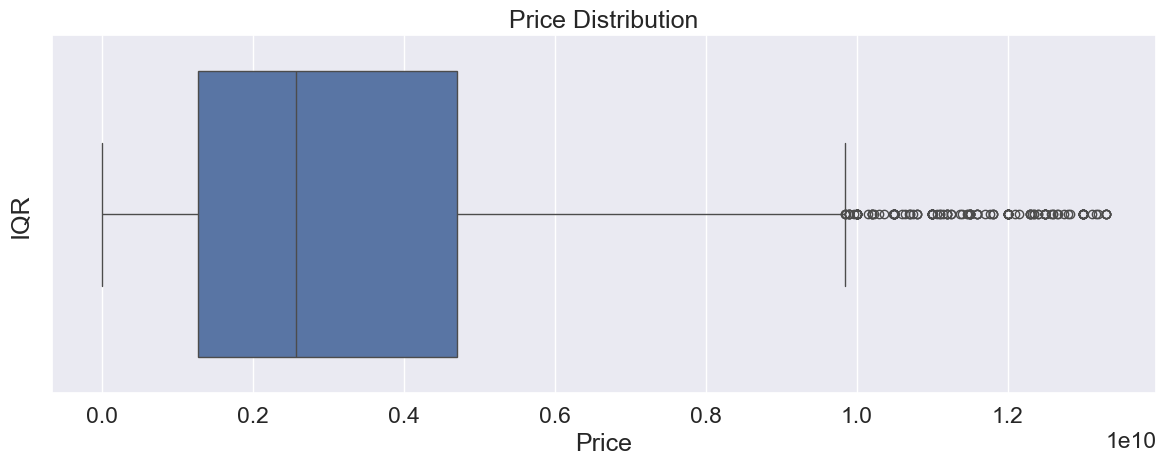

In [60]:
plt.figure(figsize = (12, 5))
sns.boxplot(x = Dataset_Without_Outliers["Price"])
plt.title('Price Distribution')
plt.ylabel('IQR')
plt.tight_layout()

In [61]:
# Select only numeric columns from Dataset_Without_Outliers
numeric_data = Dataset_Without_Outliers.select_dtypes(include='number')

# Calculate skewness for numeric columns
skewness = numeric_data.skew()
print(skewness)


Area          0.77160451
Room          0.20109521
Price         1.30185413
Price(USD)    1.30185413
dtype: float64


* Now we have more balanced data and its ready to be used for fitting.
* Due to we have dropped lots of data from dataset we can use of both(with outliers and without) to check the

We will convert Boolean features to numeric to prepare them for our model.

In [62]:
boolean_features = ['Parking', 'Warehouse', 'Elevator']
dataset[boolean_features] = dataset[boolean_features].astype(int)
dataset.tail()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),AreaSize,PriceLevel
3243,63,1,1,1,0,FeizGarden,1890000000.0,63000.00,AveUnderMean,AveUnderMean
3244,86,2,1,1,1,SouthernJanatabad,3500000000.0,116666.67,AveUnderMean,AveUpperMean
3245,83,2,1,1,1,Niavaran,6800000000.0,226666.67,AveUnderMean,Expensive
3246,105,2,1,1,1,Dorous,5600000000.0,186666.67,AveUpperMean,AveUpperMean
3247,82,2,0,1,1,Parand,360000000.0,12000.00,AveUnderMean,Cheap


* We will convert Categorical features to numeric to prepare them for our model(using dummy).* 
Creating a new variable named data and save new changes into that variabl.
* Actually, with convering categorical features(specially Address feature), we are creating somehow a Sparse Matrix.x.rix.

In [63]:
categoriacl_features = pd.get_dummies(dataset[["Address",'AreaSize' , "PriceLevel"]])
dataset=dataset.merge(categoriacl_features , left_index=True , right_index=True)
dataset.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),AreaSize,PriceLevel,Address_Abazar,Address_Abbasabad,Address_Absard,Address_Abuzar,Address_Afsarieh,Address_Ahang,Address_Airforce,Address_Ajudaniye,Address_AlborzComplex,Address_AliabadSouth,Address_AmirBahador,Address_Amirabad,Address_Amirieh,Address_Andisheh,Address_Aqdasieh,Address_Araj,Address_Argentina,Address_Atabak,Address_Azadshahr,Address_Azarbaijan,Address_Azari,Address_Baghestan,Address_Bahar,Address_Baqershahr,Address_Beryanak,Address_Boloorsazi,Address_CentralJanatabad,Address_Chahardangeh,Address_Chardangeh,Address_Chardivari,Address_Chidz,Address_Damavand,Address_Darabad,Address_Darakeh,Address_Darband,Address_DaryanNo,Address_DehkadeOlampic,Address_Dezashib,Address_Dolatabad,Address_Dorous,Address_EastFerdowsBoulevard,Address_EastPars,Address_Ekbatan,Address_Ekhtiarieh,Address_Elahieh,Address_ElmoSanat,Address_Enghelab,Address_Eram,Address_Eskandari,Address_Fallah,Address_Farmanieh,Address_Fatemi,Address_FeizGarden,Address_Firoozkooh,Address_FiroozkoohKuhsar,Address_Gandhi,Address_GardenofSaba,Address_Gheitarieh,Address_Ghiyamdasht,Address_Ghoba,Address_Gholhak,Address_Gisha,Address_Golestan,Address_HaftTir,Address_Hakimiyeh,Address_Hashemi,Address_HassanAbad,Address_Hekmat,Address_Heravi,Address_Heshmatieh,Address_HorSquare,Address_Islamshahr,Address_IslamshahrElahieh,Address_Javadiyeh,Address_Jeyhoon,Address_Jordan,Address_Kahrizak,Address_Kamranieh,Address_Karimkhan,Address_Karoon,Address_Kazemabad,Address_KeshavarzBoulevard,Address_KhademabadGarden,Address_Khavaran,Address_Komeil,Address_Koohsar,Address_Kook,Address_Lavasan,Address_Lavizan,Address_Mahallati,Address_Mahmoudieh,Address_Majidieh,Address_Malard,Address_Marzdaran,Address_Mehrabad,Address_MehrabadRiverRiver,Address_Mehran,Address_Mirdamad,Address_MirzaShirazi,Address_Moniriyeh,Address_Narmak,Address_NasimShahr,Address_Nawab,Address_Naziabad,Address_Nezamabad,Address_Niavaran,Address_NorthProgramOrganization,Address_NorthernChitgar,Address_NorthernJanatabad,Address_NorthernSuhrawardi,Address_NorthrenJamalzadeh,Address_OstadMoein,Address_Ozgol,Address_Pakdasht,Address_PakdashtKhatunAbad,Address_Parand,Address_Parastar,Address_Pardis,Address_Pasdaran,Address_PersianGulfMartyrsLake,Address_Pirouzi,Address_Pishva,Address_Punak,Address_Qalandari,Address_Qarchak,Address_QasrodDasht,Address_QazvinImamzadehHassan,Address_Railway,Address_Ray,Address_RayMontazeri,Address_RayPilgosh,Address_Razi,Address_Republic,Address_RobatKarim,Address_Rudhen,Address_SaadatAbad,Address_SabaShahr,Address_Sabalan,Address_Sadeghieh,Address_Safadasht,Address_Salehabad,Address_Salsabil,Address_Sattarkhan,Address_SeyedKhandan,Address_Shadabad,Address_Shahedshahr,Address_ShahrAra,Address_ShahrakeApadana,Address_ShahrakeAzadi,Address_ShahrakeGharb,Address_ShahrakeMadaen,Address_ShahrakeQods,Address_ShahrakeQuds,Address_ShahrakeShahidBagheri,Address_ShahrakehNaft,Address_Shahran,Address_ShahreZiba,Address_Shahryar,Address_ShamsAbad,Address_Shoosh,Address_SiMetriJi,Address_Sohanak,Address_SouthernChitgar,Address_SouthernJanatabad,Address_SouthernProgramOrganization,Address_SouthernSuhrawardi,Address_Tajrish,Address_Tarasht,Address_Taslihat,Address_TehranNow,Address_Tehransar,Address_Telecommunication,Address_Tenant,Address_ThirteenNovember,Address_Vahidieh,Address_Vahidiyeh,Address_Valiasr,Address_Vanak,Address_VaraminBeheshti,Address_Velenjak,Address_Villa,Address_WaterOrganization,Address_Waterfall,Address_WestFerdowsBoulevard,Address_WestPars,Address_Yaftabad,Address_Yakhchiabad,Address_YousefAbad,Address_Zafar,Address_Zaferanieh,Address_Zargandeh,Address_Zibadasht,AreaSize_AveUnderMean,AreaSize_AveUpperMean,AreaSize_High,AreaSize_Small,PriceLevel_AveUnderMean,PriceLevel_AveUpperMean,PriceLevel_Cheap,PriceLevel_Expensive
0,63,1,1,1,1,Shahran,1850000000.0,61666.67,AveUnderMean,AveUnderMean,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

* We will drop all the features which we dont need them(we have already converted them to the numeric features).
* Price(USD) is just an additional feature and to avoid redundancy we drop it.
* Creating a new variable named prepared_dataset and save the last changes into that variable.

In [64]:
prepared_dataset = dataset.drop(["Address",'AreaSize' , "PriceLevel" , "Price(USD)"],axis=1)
prepared_dataset.head()

,Area,Room,Parking,Warehouse,Elevator,Price,Address_Abazar,Address_Abbasabad,Address_Absard,Address_Abuzar,Address_Afsarieh,Address_Ahang,Address_Airforce,Address_Ajudaniye,Address_AlborzComplex,Address_AliabadSouth,Address_AmirBahador,Address_Amirabad,Address_Amirieh,Address_Andisheh,Address_Aqdasieh,Address_Araj,Address_Argentina,Address_Atabak,Address_Azadshahr,Address_Azarbaijan,Address_Azari,Address_Baghestan,Address_Bahar,Address_Baqershahr,Address_Beryanak,Address_Boloorsazi,Address_CentralJanatabad,Address_Chahardangeh,Address_Chardangeh,Address_Chardivari,Address_Chidz,Address_Damavand,Address_Darabad,Address_Darakeh,Address_Darband,Address_DaryanNo,Address_DehkadeOlampic,Address_Dezashib,Address_Dolatabad,Address_Dorous,Address_EastFerdowsBoulevard,Address_EastPars,Address_Ekbatan,Address_Ekhtiarieh,Address_Elahieh,Address_ElmoSanat,Address_Enghelab,Address_Eram,Address_Eskandari,Address_Fallah,Address_Farmanieh,Address_Fatemi,Address_FeizGarden,Address_Firoozkooh,Address_FiroozkoohKuhsar,Address_Gandhi,Address_GardenofSaba,Address_Gheitarieh,Address_Ghiyamdasht,Address_Ghoba,Address_Gholhak,Address_Gisha,Address_Golestan,Address_HaftTir,Address_Hakimiyeh,Address_Hashemi,Address_HassanAbad,Address_Hekmat,Address_Heravi,Address_Heshmatieh,Address_HorSquare,Address_Islamshahr,Address_IslamshahrElahieh,Address_Javadiyeh,Address_Jeyhoon,Address_Jordan,Address_Kahrizak,Address_Kamranieh,Address_Karimkhan,Address_Karoon,Address_Kazemabad,Address_KeshavarzBoulevard,Address_KhademabadGarden,Address_Khavaran,Address_Komeil,Address_Koohsar,Address_Kook,Address_Lavasan,Address_Lavizan,Address_Mahallati,Address_Mahmoudieh,Address_Majidieh,Address_Malard,Address_Marzdaran,Address_Mehrabad,Address_MehrabadRiverRiver,Address_Mehran,Address_Mirdamad,Address_MirzaShirazi,Address_Moniriyeh,Address_Narmak,Address_NasimShahr,Address_Nawab,Address_Naziabad,Address_Nezamabad,Address_Niavaran,Address_NorthProgramOrganization,Address_NorthernChitgar,Address_NorthernJanatabad,Address_NorthernSuhrawardi,Address_NorthrenJamalzadeh,Address_OstadMoein,Address_Ozgol,Address_Pakdasht,Address_PakdashtKhatunAbad,Address_Parand,Address_Parastar,Address_Pardis,Address_Pasdaran,Address_PersianGulfMartyrsLake,Address_Pirouzi,Address_Pishva,Address_Punak,Address_Qalandari,Address_Qarchak,Address_QasrodDasht,Address_QazvinImamzadehHassan,Address_Railway,Address_Ray,Address_RayMontazeri,Address_RayPilgosh,Address_Razi,Address_Republic,Address_RobatKarim,Address_Rudhen,Address_SaadatAbad,Address_SabaShahr,Address_Sabalan,Address_Sadeghieh,Address_Safadasht,Address_Salehabad,Address_Salsabil,Address_Sattarkhan,Address_SeyedKhandan,Address_Shadabad,Address_Shahedshahr,Address_ShahrAra,Address_ShahrakeApadana,Address_ShahrakeAzadi,Address_ShahrakeGharb,Address_ShahrakeMadaen,Address_ShahrakeQods,Address_ShahrakeQuds,Address_ShahrakeShahidBagheri,Address_ShahrakehNaft,Address_Shahran,Address_ShahreZiba,Address_Shahryar,Address_ShamsAbad,Address_Shoosh,Address_SiMetriJi,Address_Sohanak,Address_SouthernChitgar,Address_SouthernJanatabad,Address_SouthernProgramOrganization,Address_SouthernSuhrawardi,Address_Tajrish,Address_Tarasht,Address_Taslihat,Address_TehranNow,Address_Tehransar,Address_Telecommunication,Address_Tenant,Address_ThirteenNovember,Address_Vahidieh,Address_Vahidiyeh,Address_Valiasr,Address_Vanak,Address_VaraminBeheshti,Address_Velenjak,Address_Villa,Address_WaterOrganization,Address_Waterfall,Address_WestFerdowsBoulevard,Address_WestPars,Address_Yaftabad,Address_Yakhchiabad,Address_YousefAbad,Address_Zafar,Address_Zaferanieh,Address_Zargandeh,Address_Zibadasht,AreaSize_AveUnderMean,AreaSize_AveUpperMean,AreaSize_High,AreaSize_Small,PriceLevel_AveUnderMean,PriceLevel_AveUpperMean,PriceLevel_Cheap,PriceLevel_Expensive
0,63,1,1,1,1,1850000000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

In [65]:
prepared_dataset.dtypes

Area                                     int64
Room                                     int64
Parking                                  int32
Warehouse                                int32
Elevator                                 int32
Price                                  float64
Address_Abazar                            bool
Address_Abbasabad                         bool
Address_Absard                            bool
Address_Abuzar                            bool
Address_Afsarieh                          bool
Address_Ahang                             bool
Address_Airforce                          bool
Address_Ajudaniye                         bool
Address_AlborzComplex                     bool
Address_AliabadSouth                      bool
Address_AmirBahador                       bool
Address_Amirabad                          bool
Address_Amirieh                           bool
Address_Andisheh                          bool
Address_Aqdasieh                          bool
Address_Araj 

Creating our X and y (X all features except Price)
Converting them to test and train

In [66]:
X = prepared_dataset.drop(["Price"],axis=1)
y = prepared_dataset["Price"]

In [67]:
X_train , X_test , y_train , y_test  = train_test_split(X , y , test_size=.2 , random_state=0)

* We dont need to use of StandardScaler or any normelizition method due to :
Our X features dont need to be scaled.

* Due to better prediction but otherwise we can uncomment these three lines for normalization

In [68]:
print("X Train and Test Shape :")
print(f'X_train : {X_train.shape}')
print(f'X_test : {X_test.shape}')
print("---" * 10)
print("y Train and Test shape :")
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

X Train and Test Shape :
X_train : (2598, 205)
X_test : (650, 205)
------------------------------
y Train and Test shape :
y_train : (2598,)
y_test : (650,)


# Model Building

In [69]:
Model_Name  = []
Train_Score = []
Test_Score  = []
MSE_Score   = []
RMSE_Score  = []
Time_Score  = []

In [70]:
def model_prediction(model):
    
    start_time = time.time()
    model.fit(X_train , y_train)
    y_prediction = model.predict(X_test)
    TrainScore = model.score(X_train , y_train)
    TestScore = model.score(X_test , y_test)
    MSEscore = mean_squared_error(y_test , y_prediction)
    RMSEscore = np.sqrt(MSEscore)
    end_time = time.time()
    Timescore = end_time - start_time
    
    Name = str(model).split('(')[0]
    Model_Name.append(Name)
    Train_Score.append(TrainScore)
    Test_Score.append(TestScore)
    MSE_Score.append(MSEscore)
    RMSE_Score.append(RMSEscore)
    Time_Score.append(Timescore)

    print(f'Name of the model is : {Name}')
    print('----'*10)
    print(f'R2 score for Training : {TrainScore} ')
    print(f'R2 score for Testing : {TestScore} ')
    print("----" * 10)
    print(f'The MSE score is: {MSEscore}')
    print(f'The RMSE score is: {RMSEscore}')
    print("----" * 10)
    print(f'Time score is: {Timescore}')

### 1. Ridge Model

In [71]:
model_prediction(Ridge())

Name of the model is : Ridge
----------------------------------------
R2 score for Training : 0.6432934519657532 
R2 score for Testing : 0.509766192220882 
----------------------------------------
The MSE score is: 3.871914750769466e+19
The RMSE score is: 6222471173.713435
----------------------------------------
Time score is: 0.08451628684997559


## 2. Lasso Model

In [72]:
model_prediction(Lasso())

Name of the model is : Lasso
----------------------------------------
R2 score for Training : 0.6540331564603862 
R2 score for Testing : 0.4446093084276709 
----------------------------------------
The MSE score is: 4.386530216838618e+19
The RMSE score is: 6623088567.155521
----------------------------------------
Time score is: 2.4817676544189453


## 3. ElasticNet Model

In [73]:
model_prediction(ElasticNet())

Name of the model is : ElasticNet
----------------------------------------
R2 score for Training : 0.40575840299303445 
R2 score for Testing : 0.39834750582781575 
----------------------------------------
The MSE score is: 4.7519104763009974e+19
The RMSE score is: 6893410241.891163
----------------------------------------
Time score is: 0.571178674697876


## 4. LinearRegression Model

In [74]:
model_prediction(LinearRegression())

Name of the model is : LinearRegression
----------------------------------------
R2 score for Training : 0.6540331564603579 
R2 score for Testing : 0.44437768018816026 
----------------------------------------
The MSE score is: 4.388359639418262e+19
The RMSE score is: 6624469517.945012
----------------------------------------
Time score is: 0.13505816459655762


## 5. DecisionTreeRegressor Model

In [75]:
model_prediction(DecisionTreeRegressor())

Name of the model is : DecisionTreeRegressor
----------------------------------------
R2 score for Training : 0.9929028591543528 
R2 score for Testing : 0.45288957215109404 
----------------------------------------
The MSE score is: 4.321131880897192e+19
The RMSE score is: 6573531684.6404505
----------------------------------------
Time score is: 0.0605158805847168


## 7. RandomForestRegressor Model

In [76]:
model_prediction(RandomForestRegressor())

Name of the model is : RandomForestRegressor
----------------------------------------
R2 score for Training : 0.9633832559260059 
R2 score for Testing : 0.7960668361439924 
----------------------------------------
The MSE score is: 1.6106841526950205e+19
The RMSE score is: 4013332969.858121
----------------------------------------
Time score is: 1.7383205890655518


## 8. KNeighborsRegressor Model

In [77]:
model_prediction(KNeighborsRegressor())

Name of the model is : KNeighborsRegressor
----------------------------------------
R2 score for Training : 0.7251591616240536 
R2 score for Testing : 0.5968502320322464 
----------------------------------------
The MSE score is: 3.1841164534024684e+19
The RMSE score is: 5642797580.458179
----------------------------------------
Time score is: 0.2572963237762451


## 9. LGBMRegressor Model

In [78]:
model_prediction(LGBMRegressor())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 2598, number of used features: 46
[LightGBM] [Info] Start training from score 5447985413.715165
Name of the model is : LGBMRegressor
----------------------------------------
R2 score for Training : 0.8507838092281415 
R2 score for Testing : 0.7778399816768047 
----------------------------------------
The MSE score is: 1.7546416390041459e+19
The RMSE score is: 4188844278.5619826
----------------------------------------
Time score is: 0.19287919998168945


## 10. AdaBoostRegressor Model

In [79]:
model_prediction(AdaBoostRegressor())

Name of the model is : AdaBoostRegressor
----------------------------------------
R2 score for Training : 0.7350518079626587 
R2 score for Testing : 0.6741036098918569 
----------------------------------------
The MSE score is: 2.573961689420615e+19
The RMSE score is: 5073422601.5783615
----------------------------------------
Time score is: 0.443798303604126


## 11. XGBRegressor Model

In [80]:
model_prediction(XGBRegressor())

Name of the model is : XGBRegressor
----------------------------------------
R2 score for Training : 0.9873131216170784 
R2 score for Testing : 0.7718064775798944 
----------------------------------------
The MSE score is: 1.802294846802047e+19
The RMSE score is: 4245344328.5581055
----------------------------------------
Time score is: 0.7506530284881592


Checking all models score

In [81]:
chart_df = pd.DataFrame({'Algorithms': Model_Name,
                         'Train': Train_Score,
                         'Test': Test_Score,
                         'MSE': MSE_Score,
                         'RMSE': RMSE_Score,
                         'Time': Time_Score})

In [82]:
chart_df

,Algorithms,Train,Test,MSE,RMSE,Time
0,Ridge,0.64329345,0.50976619,3.87191475e+19,6.22247117e+09,0.08451629
1,Lasso,0.65403316,0.44460931,4.38653022e+19,6.62308857e+09,2.48176765
2,ElasticNet,0.40575840,0.39834751,4.75191048e+19,6.89341024e+09,0.57117867
3,LinearRegression,0.65403316,0.44437768,4.38835964e+19,6.62446952e+09,0.13505816
4,DecisionTreeRegressor,0.99290286,0.45288957,4.32113188e+19,6.57353168e+09,0.06051588
5,RandomForestRegressor,0.96338326,0.79606684,1.61068415e+19,4.01333297e+09,1.73832059
6,KNeighborsRegressor,0.72515916,0.59685023,3.18411645e+19,5.64279758e+09,0.25729632
7,LGBMRegressor,0.85078381,0.77783998,1.75464164e+19,4.18884428e+09,0.19287920
8,AdaBoostRegressor,0.73505181,0.67410361,2.57396169e+19,5.07342260e+09,0.44379830
9,XGBRegressor,0.98731312,0.77180648,1.80229485e+19,4.24534433e+09,0.75065303


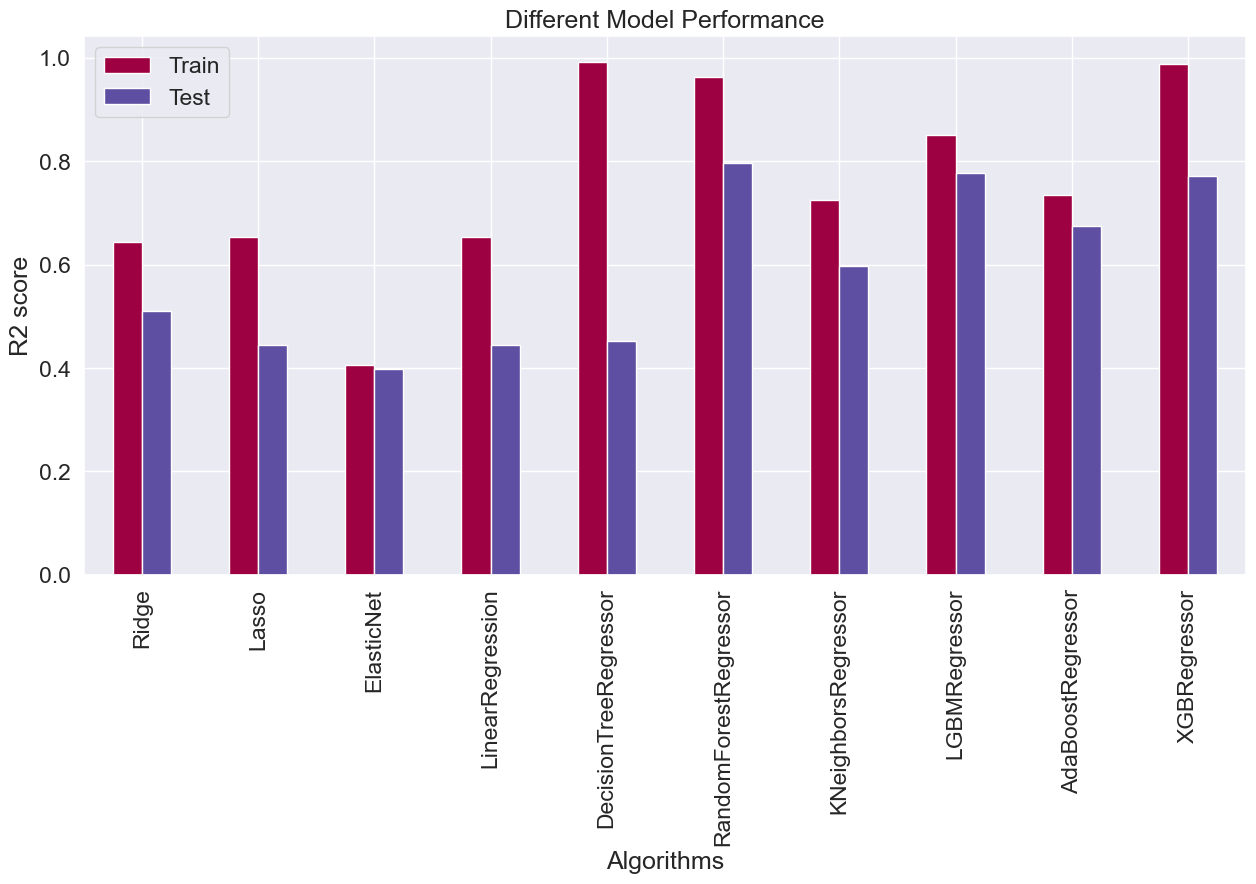

In [83]:
chart_df.plot(x = 'Algorithms', y = ['Train', 'Test'], kind = "bar", figsize = (15, 7),
              title = "Different Model Performance", colormap = "Spectral")
plt.ylabel('R2 score')
plt.show()

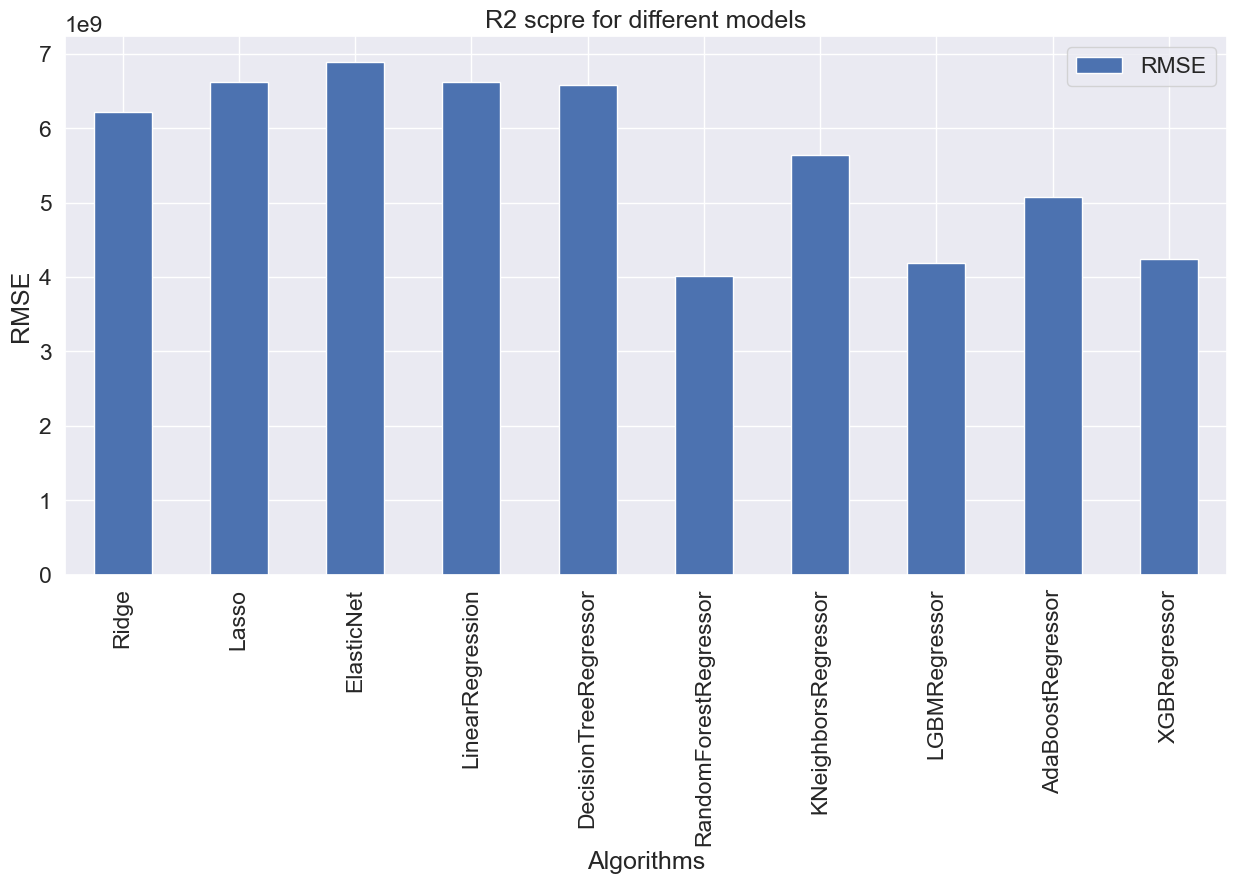

In [84]:
chart_df.plot(x = 'Algorithms', y = ['RMSE'], kind = "bar", figsize = (15, 7), title = "R2 scpre for different models")
plt.ylabel("RMSE")
plt.show()

1: Among regularization , we can see Ridge have the best performance (L2).

2: LinearRegression has the worst performance .

3: DecisionTree with spite the fact that has the best fitting but we can observe huge overfiiting .

4: RandomForest and XGBRegressor have roughly the same performance and both have good performance.

5: KNeighborsRegressor has bad performance too .

6: LGBMRegressor and AdaBoostRegressor have the same performance but LGBM has a little better performance.

Conclusion:

We are going to use the 3 best models for Hyper-Parameter Tunning (RandomForestRegressor,XGBResgressor,LGBMRegressor)

# Hyper-Parameter Tuning for the best models

In [85]:
Model_Name_Best = []
Train_Score_Best= []
Test_Score_Best = []
MSE_Score_Best  = []
RMSE_Score_Best = []
Time_Score_Best = []

In [86]:
def Model_Parameter_Prediction( model , parameter):
    
    Start_time = time.time()

    Grid_Search = GridSearchCV(estimator=model, param_grid=parameter ,scoring=None , n_jobs= -1 ,refit=True ,
    cv=KFold(n_splits=5 , shuffle=True , random_state=1))

    Grid_Fit = Grid_Search.fit(X_train , y_train)

    y_Prediction = Grid_Fit.predict(X_test)

    Train_score = Grid_Fit.score(X_train , y_train)
    Test_score = Grid_Fit.score(X_test , y_test)
    MSE_score = mean_squared_error(y_test , y_Prediction)
    RMSE_score = np.sqrt(MSE_score)
    Name = str(model).split('(')[0]
    Best_Parameter = Grid_Fit.best_params_
    
    End_time = time.time()

    Model_Name_Best.append(Name)
    Train_Score_Best.append(Train_score)
    Test_Score_Best.append(Test_score)
    MSE_Score_Best.append(MSE_score)
    RMSE_Score_Best.append(RMSE_score)
    Time_Score_Best.append(End_time)

    print(f'Name of model is : {Name}')
    print(f'The best parameters are : {Best_Parameter}')

    print('--'*25)
    print(f'R2 Score for Training is : {Train_score} ')
    print(f'R2 Score for Testing is : {Test_score} ')

    print('--'*25)
    print(f'MSE Score is : {MSE_score}')
    print(f'RMSE Score is : {RMSE_score}')

    print('--'*25)

    print(f"Process Time is : {round(End_time)}")

## 1. RandomForestRegressor Hyper-Parameter Tunning

In [87]:
randomforest = RandomForestRegressor(random_state = 1)
Parameters_forest = {
                    'n_estimators': [120,140,150],
                    # 'max_depth': [13,14,15],
                    # 'min_samples_split' :[1,2,3],
                    # 'min_samples_leaf':[1,2,3]
                    }
Model_Parameter_Prediction(randomforest, Parameters_forest)

Name of model is : RandomForestRegressor
The best parameters are : {'n_estimators': 140}
--------------------------------------------------
R2 Score for Training is : 0.9632971640337346 
R2 Score for Testing is : 0.8038431773666666 
--------------------------------------------------
MSE Score is : 1.5492658461455565e+19
RMSE Score is : 3936071450.2477674
--------------------------------------------------
Process Time is : 1729883143


## 2. XGBRegressor Hyper-Parameter Tunning

In [88]:
xgbregression = XGBRegressor()
Parameters_xgbr={
                  'n_estimators':[10,11,12] ,
                # 'max_depth':[5,6,7,8],
                # 'learning_rate':[0.03 ,0.05 , 0.07],
                # 'colsample_bytree': [1],
                #  'subsample': [0.5 , 0.75 , 0.9],
                }
Model_Parameter_Prediction(xgbregression , Parameters_xgbr)

Name of model is : XGBRegressor
The best parameters are : {'n_estimators': 12}
--------------------------------------------------
R2 Score for Training is : 0.9337898108767542 
R2 Score for Testing is : 0.8050782508033005 
--------------------------------------------------
MSE Score is : 1.5395111148689637e+19
RMSE Score is : 3923660427.2910314
--------------------------------------------------
Process Time is : 1729883145


## 3. LGBMRegressor Hyper-Parameter Tunning

In [89]:
lgbmregression = LGBMRegressor()
Parameters_lgbm={
                  'n_estimators':[200,250,300] ,
                # 'max_depth':[5,6,7,8],
                # 'learning_rate':[0.07 , 0.09 , 0.1]
                # 'colsample_bytree': [1]
                # 'subsample': [0.50 , 0.75 , 0.9],
                }
Model_Parameter_Prediction(lgbmregression , Parameters_lgbm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 2598, number of used features: 46
[LightGBM] [Info] Start training from score 5447985413.715165
Name of model is : LGBMRegressor
The best parameters are : {'n_estimators': 250}
--------------------------------------------------
R2 Score for Training is : 0.8855044359421032 
R2 Score for Testing is : 0.7813133948766965 
--------------------------------------------------
MSE Score is : 1.7272082804907764e+19
RMSE Score is : 4155969538.4961333
--------------------------------------------------
Process Time is : 1729883152


Checking all the best models scores

In [90]:
chart_df_Best = pd.DataFrame({'Algorithms':Model_Name_Best,
            'Train':Train_Score_Best , 
            'Test':Test_Score_Best, 
            'MSE' :MSE_Score_Best,
            'RMSE':RMSE_Score_Best,
            'Time':Time_Score_Best })

In [91]:
chart_df_Best

,Algorithms,Train,Test,MSE,RMSE,Time
0,RandomForestRegressor,0.96329716,0.80384318,1.54926585e+19,3.93607145e+09,1.72988314e+09
1,XGBRegressor,0.93378981,0.80507825,1.53951111e+19,3.92366043e+09,1.72988314e+09
2,LGBMRegressor,0.88550444,0.78131339,1.72720828e+19,4.15596954e+09,1.72988315e+09


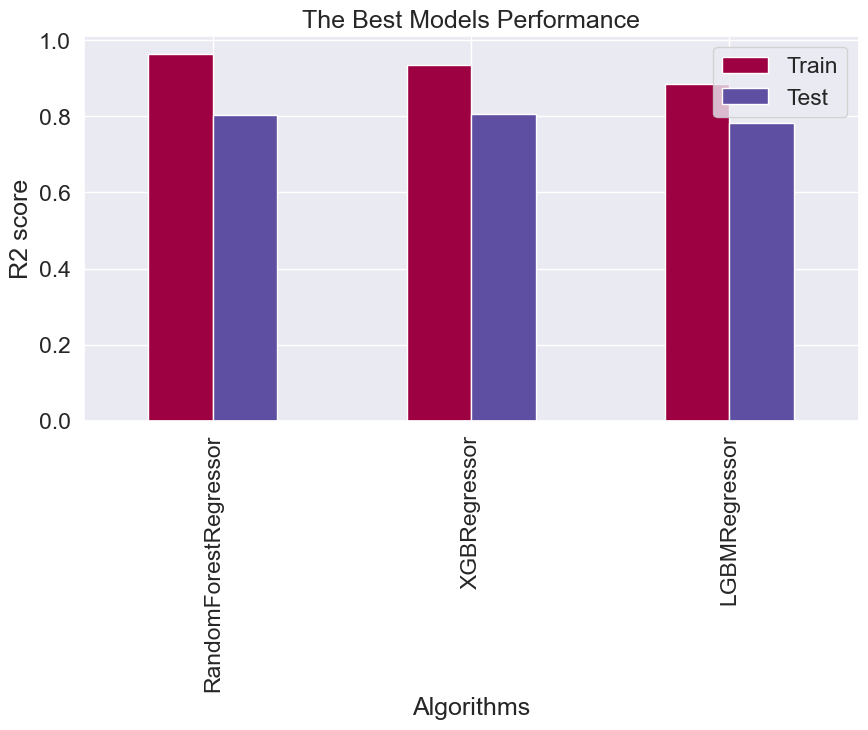

In [92]:
chart_df_Best.plot(x = 'Algorithms', y = ['Train', 'Test'], kind = "bar", figsize = (10, 5),
                   title = "The Best Models Performance", colormap = "Spectral")
plt.ylabel("R2 score")
plt.show()

RandomForest and XGB are the models with the highest performance and closely they have the same performance.
But it can be seen that , overfitting is a little more seen in Randomforest.

# Save Model

In [93]:
import joblib

Model_Add = 'BestModel.pkl'  # Specify the filename with .pkl extension
joblib.dump(best_model, Model_Add)  # Replace 'best_model' with your actual model variable

NameError: name 'best_model' is not defined

### Summary

1: First,we checked quickly our dataset .

2: Then ,EDA done to get some details about the dataset.

3: FeatueEngeering to create some new relevent features.

4: preprocessing to prepare our dataset for model building(with and without outliers).

5: we done model building and checked the prefromance for each one.

6: seen that Randomforest , XGB , LGBM have the best performance.

7: done HyperParameter Tunning for the best models.

8: last ,saved model in case we need.